# Trabalho Final de Datamining
## Yuri Lopes e Maurício Júnior

# Pré-processamento dos Dados

In [30]:
import numpy as np
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import pandas as pd
import matplotlib.pyplot as plt

import copy

Carregamos os dados de teste e treino.

Após isso, removemos as colunas constantes e duplicadas.

In [45]:
data_train = pd.read_csv("new_train.csv")
data_test = pd.read_csv("test.csv")

#TODO concatenar dataset de treino e teste para fazer essas verificações para remoção

#verificação de colunas constantes
list_remove = []
for col in data_train.columns:
    if data_train[col].std() == 0: #se o desvio padrão da coluna for zero, ela é constante
        list_remove.append(col)
        
#removo as colunas constantes dos datasets
data_train.drop(list_remove, axis=1, inplace=True)
data_test.drop(list_remove, axis=1, inplace=True)

#verificação de colunas duplicadas
list_remove = []
columns = data_train.columns
for i in range(len(columns) - 1):
    values = data_train[columns[i]].values
    for j in range(i+1, len(columns)):
        if np.array_equal(values, data_train[columns[j]].values):
            list_remove.append(columns[j])

data_train.drop(list_remove, axis=1, inplace=True)
data_test.drop(list_remove, axis=1, inplace=True)
data_test_original = copy.deepcopy(data_test)

# Seleção de Features

Separamos as features do target. Também dividimos o conjunto dos dados para treino e teste.

In [56]:
X = data_train.drop(["TARGET"], axis=1)
y = data_train.TARGET.values
data_test = data_test_original

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print("X_train:   ", X_train.shape)
print("X_test:    ", X_test.shape)
print("data_test: ", data_test.shape)

X_train:    (48016, 305)
X_test:     (12004, 305)
data_test:  (16000, 305)


### Importância das Features

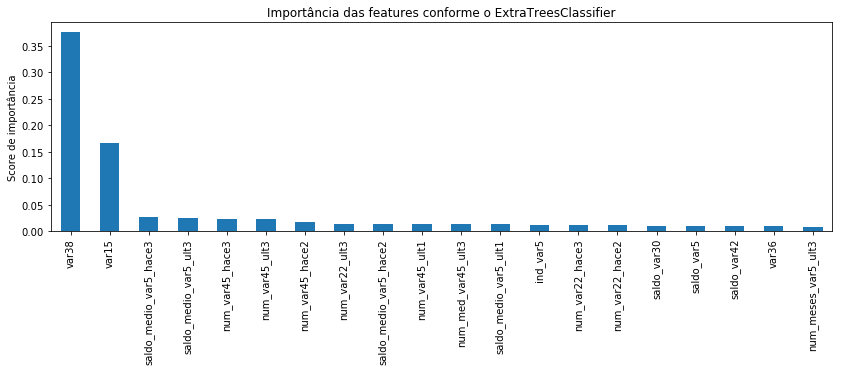

In [57]:
#Uso um classificador de ensemble ExtraTreesClassifier porque:
# This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various 
#  sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

clf = ExtraTreesClassifier()
feature_selector = clf.fit(X_train, y_train)

feature_importance = pd.Series(clf.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)
feature_importance[:20].plot(kind='bar', title='Importância das features conforme o ExtraTreesClassifier', figsize=(14, 5))
plt.ylabel('Score de importância')
plt.subplots_adjust(bottom=0.3)
plt.show()

Fazemos a seleção das features mais importantes e, cortamos nossos dados conforme essas features.

In [58]:
sfm = SelectFromModel(feature_selector, prefit=True) #o classifier já foi fitado

X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)
data_test = sfm.transform(data_test)

print("X_train:   ", X_train.shape)
print("X_test:    ", X_test.shape)
print("data_test: ", data_test.shape)

X_train:    (48016, 37)
X_test:     (12004, 37)
data_test:  (16000, 37)


# Treino e Classificação

In [59]:
xgbClf = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth=4)
xgbClf.fit(X_train, y_train, eval_metric="auc", verbose=False, eval_set=[(X_test, y_test)])

print("AUC: ", roc_auc_score(y_test, xgbClf.predict_proba(X_test)[:, 1]))

AUC:  0.831519639431


Salvamos o resultado da classificação do dataset de teste num arquivo.

In [61]:
y_predicted = xgbClf.predict_proba(data_test)[:, 1]
np.savetxt('submission.txt', y_predicted, delimiter=',')